In [31]:
from scipy.special import erf
import numpy as np
from math import factorial, sqrt
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [32]:
# ============================================================
# 1. Probabilists' Hermite polynomials He_k (variance 1)
# ============================================================

def hermite_He_values(z, k_max):
    """
    Probabilists' Hermite polynomials, variance 1:
        He_0(x) = 1
        He_1(x) = x
        He_{k+1}(x) = x * He_k(x) - k * He_{k-1}(x)

    Returns array [He_0(z), ..., He_{k_max}(z)].
    """
    He = np.zeros(k_max + 1, dtype=float)
    He[0] = 1.0
    if k_max >= 1:
        He[1] = z
    for k in range(1, k_max):
        He[k + 1] = z * He[k] - k * He[k - 1]
    return He


def hermite_He_r(x, k, r):
    """
    Hermite polynomials adapted to variance r:

        He_k^[r](x) = r^{k/2} * He_k(x / sqrt(r)),

    where He_k is the variance-1 probabilists' Hermite.

    This is the family orthogonal w.r.t. X ~ N(0, r).
    """
    sqrt_r = sqrt(r)
    z = x / sqrt_r    # reduce to variance-1 variable
    He_vals = hermite_He_values(z, k)
    return (r ** (k / 2.0)) * He_vals[k]


# ============================================================
# 2. Gaussian expectation E[f(Z)] with Z ~ N(0,1)
# ============================================================

#def gaussian_expectation(f, limit=200):
#    """
#    Compute E[f(Z)] for Z ~ N(0,1):
#        E[f(Z)] = ∫ f(z) φ(z) dz
#    with φ(z) = exp(-z^2/2) / sqrt(2π).
#    """
#    norm_const = 1.0 / np.sqrt(2.0 * np.pi)

#   def integrand(z):
#       return f(z) * np.exp(-0.5 * z * z) * norm_const

#    val, err = quad(integrand, -np.inf, np.inf, limit=limit)
#    return val

def gaussian_expectation(f, n_gh=80):
    """
    Compute E[f(Z)] for Z ~ N(0,1) using Gauss–Hermite quadrature.

    E[f(Z)] = 1/sqrt(pi) * sum_i w_i * f(sqrt(2) * x_i),
    where (x_i, w_i) are Gauss–Hermite nodes and weights
    for the weight exp(-x^2).

    n_gh: number of quadrature points (e.g. 40, 80, 120).
          Larger = more accurate but more expensive.
    """
    x, w = np.polynomial.hermite.hermgauss(n_gh)

    # map x -> z = sqrt(2) x to match N(0,1)
    z = np.sqrt(2.0) * x
    vals = f(z)

    # Expectation under N(0,1)
    return (w @ vals) / np.sqrt(np.pi)



# ============================================================
# 3. Hermite coefficients:
#    σ_k with He_k (variance 1),
#    σ_k^[r], \barσ_k^[r] with He_k^[r] (variance r)
# ============================================================

def compute_sigma_coeffs(
    r,
    k_max,
    sigma_r,
    sigma_r_prime,
    sigma_base=None,
):
    r"""
    We compute three families:

    1) σ_k           = E_Z[ He_k(Z) σ_base(Z) ],
       where Z ~ N(0,1) and He_k is variance-1 probabilists' Hermite.

    2) σ_k^[r]       = E_X[ He_k^[r](X) σ_r(X) ],
       where X ~ N(0,r) and He_k^[r] is the variance-r Hermite.
       Using X = sqrt(r) Z with Z ~ N(0,1):
           σ_k^[r] = E_Z[ He_k^[r](sqrt(r) Z) σ_r(sqrt(r) Z) ].

    3) \bar{σ}_k^[r] = E_X[ X He_k^[r](X) σ_r'(X) ],
       X ~ N(0,r).
       Using X = sqrt(r) Z:
           \bar{σ}_k^[r] = E_Z[ sqrt(r) Z He_k^[r](sqrt(r) Z) σ_r'(sqrt(r) Z) ].

    This matches the conceptual distinction:
      - σ_k uses standard He_k (variance 1),
      - σ_k^[r], \bar{σ}_k^[r] use He_k^[r] (variance r).
    """
    if sigma_base is None:
        sigma_base = sigma_r

    sigma_base_coeffs = np.zeros(k_max + 1)
    sigma_r_coeffs = np.zeros(k_max + 1)
    sigma_r_bar_coeffs = np.zeros(k_max + 1)

    sqrt_r = sqrt(r)

    # ---- 1) σ_k with He_k (variance 1) ----
    for k in range(k_max + 1):
        def f_base(z, k=k):
            He_vals = hermite_He_values(z, k)
            return He_vals[k] * sigma_base(z)

        sigma_base_coeffs[k] = gaussian_expectation(f_base)

    # ---- 2) σ_k^[r] with He_k^[r] (variance r) ----
    for k in range(k_max + 1):
        def f_r(z, k=k):
            x = sqrt_r * z               # X = sqrt(r) Z
            He_r_k = hermite_He_r(x, k, r)
            return He_r_k * sigma_r(x)

        sigma_r_coeffs[k] = gaussian_expectation(f_r)

    # ---- 3) \bar{σ}_k^[r] with He_k^[r] (variance r) ----
    for k in range(k_max + 1):
        def f_r_bar(z, k=k):
            x = sqrt_r * z               # X = sqrt(r) Z
            He_r_k = hermite_He_r(x, k, r)
            return sqrt_r * z * He_r_k * sigma_r_prime(x)

        sigma_r_bar_coeffs[k] = gaussian_expectation(f_r_bar)

    return sigma_base_coeffs, sigma_r_coeffs, sigma_r_bar_coeffs


# ============================================================
# 4. A(μ), B(μ) from the coefficients (truncated to k_max)
# ============================================================

def compute_A_B(mu, sigma_base_coeffs, sigma_r_coeffs, sigma_r_bar_coeffs,degree=1):
    r"""
    Truncated versions of:

      A = -∑_{k=0}^{∞} [ \bar{σ}_k^[r] / (k! μ^{k+1}) ]
                        * [ -σ_k + σ_k^[r] / μ^k ]

      B = -∑_{k=0}^{∞} [
              ( \bar{σ}_k^[r] σ_k^[r] ) / (k! μ^{2k+2})
            + ( σ_k / ( (k-1)! μ^{k+2} ) ) * ( σ_k^[r] - \bar{σ}_k^[r]/k )
          ]

    We cut the sum at k_max where len(σ_k) = k_max + 1.
    For k = 0, the second term in B is undefined ( (k-1)!, 1/k ), so we
    include it only for k >= 1.
    """
    k_max = len(sigma_base_coeffs) - 1

    A = 0.0
    B = 0.0
    ratio = factorial(degree)*degree

    for k in range(k_max + 1):
        sigma_k = sigma_base_coeffs[k]
        sigma_r_k = sigma_r_coeffs[k]
        sigma_r_bar_k = sigma_r_bar_coeffs[k]

        # --- A contribution ---
        A += - (sigma_r_bar_k / (factorial(k) * (mu ** (k + 1)))) * (
            -sigma_k + sigma_r_k / (mu ** k)
        )

        # --- B contribution ---
        term1 = (sigma_r_bar_k * sigma_r_k) / (factorial(k) * (mu ** (2 * k + 2)))

        if k >= 1:
            term2 = sigma_k / (factorial(k - 1) * (mu ** (k + 2)))
            term2 *= (sigma_r_k - sigma_r_bar_k / k)
        else:
            term2 = 0.0

        B += - (term1 + term2)

    return A/ratio, B/ratio


# ============================================================
# 5. τ(μ) and t_exit(μ) with your formula
# ============================================================

def tau_from_A_B(A, B):
    r"""
    Your definition:
        τ(μ) = 1 / λ_+(μ)
             = (-B + sqrt(B^2 + 4 A^2)) / (2 A^2).

    We guard against A ≈ 0 to avoid division by zero.
    """
    if np.isclose(A, 0.0):
        return np.nan

    disc = B * B + 4.0 * A * A
    sqrt_disc = np.sqrt(disc)
    tau = (-B + sqrt_disc) / (2.0 * A * A)
    return tau


def t_exit_from_mu(mu, k_max, sigma_r, sigma_r_prime, sigma_base,
                   R=1.0, eps=1e-3,degree=1):
    """
    For a given μ, set r = μ^2, compute A(μ), B(μ), then:

        τ(μ) = (-B + sqrt(B^2 + 4A^2)) / (2 A^2)
        t_exit(μ) = τ(μ) * log(R / ε)

    Returns t_exit(μ). If τ is NaN, returns NaN.
    """
    r = mu ** 2

    sigma_base_coeffs, sigma_r_coeffs, sigma_r_bar_coeffs = compute_sigma_coeffs(
        r=r,
        k_max=k_max,
        sigma_r=sigma_r,
        sigma_r_prime=sigma_r_prime,
        sigma_base=sigma_base,
    )

    A, B = compute_A_B(mu, sigma_base_coeffs, sigma_r_coeffs, sigma_r_bar_coeffs,degree=degree)
    tau = tau_from_A_B(A, B)

    if np.isnan(tau):
        return np.nan

    #return tau * np.log(R / eps)
    return tau 

def hermite_generic(n, x):
    """
    Probabilists' Hermite polynomial H_n(x)
    using recursion:
    H_0(x) = 1
    H_1(x) = x
    H_{n+1}(x) = x H_n(x) - n H_{n-1}(x)
    """
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    else:
        Hnm2 = np.ones_like(x)  # H_0
        Hnm1 = x                # H_1
        for i in range(1, n):
            Hn = x * Hnm1 - i * Hnm2
            Hnm2, Hnm1 = Hnm1, Hn
        return Hn

def dhermite(n, x):
    """
    Derivative of probabilists' Hermite polynomial H_n(x)
    """
    if n == 0:
        return np.zeros_like(x)
    else:
        return n * hermite_generic(n-1, x)

In [33]:
def gaussian_expectation(f, limit=200, epsabs=1e-10, epsrel=1e-10):
    from scipy.integrate import quad
    norm_const = 1.0 / np.sqrt(2.0 * np.pi)

    def integrand(z):
        return f(z) * np.exp(-0.5 * z * z) * norm_const

    val, err = quad(
        integrand, -np.inf, np.inf,
        limit=limit,
        epsabs=epsabs,
        epsrel=epsrel
    )
    return val

In [34]:
# ============================================================
# Global config
# ============================================================

DATA_FILE = "t_exit_activations_icml_test.npz"

# μ-grid and dynamics parameters
mu_vals = np.linspace(0.032, 0.99, 200)
k_max = 16     # Hermite truncation (or generic truncation parameter)
R = 1.0        # outer radius in exit time
eps = 1e-3     # initial ball radius

# Hermite degrees
HERMITE_EVEN = [2, 6, 10, 14]
HERMITE_ODD  = [3, 5, 7, 9]

In [35]:
# ============================================================
# ICML style helper (same template as before)
# ============================================================

def set_icml_style():
    """
    Rough ICML / two-column conference style.

    - Figure width ~ two columns
    - Small fonts (8pt)
    - Thin lines, light grid
    """
    plt.rcParams.update({
        "figure.figsize": (6.75, 2.5),   # ~ two-column width, short height
        "font.size": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "legend.fontsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "lines.linewidth": 1.0,
        "axes.linewidth": 0.6,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,   # embed fonts (good for Illustrator / ICML)
        "ps.fonttype": 42,
        "axes.grid": False,
    })
    # Optional LaTeX rendering (only if your env supports it)
    # plt.rcParams["text.usetex"] = True

In [36]:
# ============================================================
# Activation definitions
# (assumes hermite_generic, dhermite, t_exit_from_mu are defined)
# ============================================================

# --- Hermite-based builders ---

def make_sigma_r_hermite(deg):
    def sigma_r(x):
        return hermite_generic(deg, x)
    return sigma_r

def make_sigma_r_prime_hermite(deg):
    def sigma_r_prime(x):
        return dhermite(deg, x)
    return sigma_r_prime

def make_sigma_base_hermite(deg):
    def sigma_base(x):
        return hermite_generic(deg, x)
    return sigma_base

# --- Standard activations: x, erf, ReLU, sigmoid ---

def sigma_x(x):
    return x

def sigma_x_prime(x):
    return np.ones_like(x)

def sigma_erf(x):
    return erf(x)

def sigma_erf_prime(x):
    return 2.0 / np.sqrt(np.pi) * np.exp(-x**2)

def sigma_relu(x):
    return np.maximum(0.0, x)

def sigma_relu_prime(x):
    x = np.asarray(x)
    return np.where(x > 0, 1.0, 0.0)

def sigma_sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigma_sigmoid_prime(x):
    s = sigma_sigmoid(x)
    return s * (1.0 - s)


# ============================================================
# Build activation configs (generic, non-redundant)
# ============================================================

def build_activation_configs():
    """
    Returns a list of configs. Each config is a dict with:
        - 'name'  : short identifier (e.g. 'x', 'erf', 'He2')
        - 'label' : TeX label for the legend
        - 'sigma_r'
        - 'sigma_r_prime'
        - 'sigma_base'
        - 'extra_args' : passed to t_exit_from_mu (e.g. degree)
    """
    configs = []

    # --- Standard activations ---
    configs.append({
        "name": "x",
        "label": r"$x$",
        "sigma_r": sigma_x,
        "sigma_r_prime": sigma_x_prime,
        "sigma_base": sigma_x,
        "extra_args": {},
    })

    configs.append({
        "name": "erf",
        "label": r"$\mathrm{erf}$",
        "sigma_r": sigma_erf,
        "sigma_r_prime": sigma_erf_prime,
        "sigma_base": sigma_erf,
        "extra_args": {},
    })

    configs.append({
        "name": "relu",
        "label": r"$\mathrm{ReLU}$",
        "sigma_r": sigma_relu,
        "sigma_r_prime": sigma_relu_prime,
        "sigma_base": sigma_relu,
        "extra_args": {},
    })

    configs.append({
        "name": "sigmoid",
        "label": r"$\mathrm{sigmoid}$",
        "sigma_r": sigma_sigmoid,
        "sigma_r_prime": sigma_sigmoid_prime,
        "sigma_base": sigma_sigmoid,
        "extra_args": {},
    })

    # --- Even Hermites ---
    for deg in HERMITE_EVEN:
        configs.append({
            "name": f"He{deg}",
            "label": rf"He$_{{{deg}}}$",
            "sigma_r": make_sigma_r_hermite(deg),
            "sigma_r_prime": make_sigma_r_prime_hermite(deg),
            "sigma_base": make_sigma_base_hermite(deg),
            "extra_args": {"degree": deg},
        })

    # --- Odd Hermites ---
    for deg in HERMITE_ODD:
        configs.append({
            "name": f"He{deg}",
            "label": rf"He$_{{{deg}}}$",
            "sigma_r": make_sigma_r_hermite(deg),
            "sigma_r_prime": make_sigma_r_prime_hermite(deg),
            "sigma_base": make_sigma_base_hermite(deg),
            "extra_args": {"degree": deg},
        })

    return configs

In [37]:
# ============================================================
# Part A — compute and save data
# ============================================================

def compute_t_exit_table(mu_vals, configs):
    """
    Compute t_exit(mu) for all activations.

    Returns:
        names  : list of short names
        labels : list of TeX labels
        T      : array shape (n_acts, n_mu)
    """
    n_acts = len(configs)
    n_mu   = len(mu_vals)
    T = np.zeros((n_acts, n_mu), dtype=float)

    names  = []
    labels = []

    for i, cfg in enumerate(configs):
        names.append(cfg["name"])
        labels.append(cfg["label"])
        t_vals = []

        for mu in mu_vals:
            t_mu = t_exit_from_mu(
                mu=mu,
                k_max=k_max,
                sigma_r=cfg["sigma_r"],
                sigma_r_prime=cfg["sigma_r_prime"],
                sigma_base=cfg["sigma_base"],
                R=R,
                eps=eps,
                **cfg["extra_args"],
            )
            t_vals.append(t_mu)

        T[i, :] = np.array(t_vals, dtype=float)

    return names, labels, T


def compute_and_save_t_exit_data(data_file=DATA_FILE):
    """
    Run this ONCE to compute all curves and save them to disk.
    """
    configs = build_activation_configs()
    names, labels, T = compute_t_exit_table(mu_vals, configs)

    np.savez(
        data_file,
        mu_vals=mu_vals,
        names=np.array(names, dtype=object),
        labels=np.array(labels, dtype=object),
        T=T,
    )
    print(f"[compute] Saved data to '{data_file}'")

In [47]:
# ============================================================
# Part B — load and plot 3-panel ICML figure
# ============================================================

def load_t_exit_data(data_file=DATA_FILE):
    data = np.load(data_file, allow_pickle=True)
    mu_vals_loaded = data["mu_vals"]
    names = list(data["names"])
    labels = list(data["labels"])
    T = data["T"]
    return mu_vals_loaded, names, labels, T


def plot_group(ax, mu_vals, group_names, names, labels, T, title=None,indx=0):
    """
    Plot a subset of activations (group_names) on a given axis.
    """
    # Map name -> (index, label)
    idx = {n: i for i, n in enumerate(names)}
    label_dict = {n: lab for n, lab in zip(names, labels)}

    # Only keep those present in data
    present = [g for g in group_names if g in idx]

    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    for color, n in zip(colors, present):
        j = idx[n]
        lab = label_dict[n]
        y = T[j, :]
        ax.plot(mu_vals[indx:], y[indx:], "-", color=color, label=lab)

    ax.set_yscale("log")
    ax.set_xlabel(r"$\mu$")
    #ax.set_ylabel(r"$t_{\mathrm{exit}}(\mu)$")
    ax.set_ylabel(r"$\tau_(\mu)$")

    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.7)

    if title is not None:
        ax.set_title(title)

    ax.legend(frameon=False, fontsize=7)


def plot_three_panel_icml(data_file=DATA_FILE,
                          out_file="t_exit_three_panels_icml_test.pdf",
                          show=True):
    """
    Produce a single ICML-style figure with 3 panels:

      (a) x, erf, ReLU, sigmoid
      (b) He2, He6, He10, He14
      (c) He3, He5, He7, He9
    """
    set_icml_style()

    mu_loaded, names, labels, T = load_t_exit_data(data_file)

    fig, axes = plt.subplots(1, 3, sharey=True)

    # Panel 1: standard activations
    group1 = ["x", "erf", "relu", "sigmoid"]
    plot_group(
        axes[0],
        mu_loaded,
        group1,
        names,
        labels,
        T,
        #title="Standard activations",
    )

    # Panel 2: even Hermite
    group2 = [f"He{d}" for d in HERMITE_EVEN]
    plot_group(
        axes[1],
        mu_loaded,
        group2,
        names,
        labels,
        T,
        indx=3
        #title="Even Hermite",
    )

    # Panel 3: odd Hermite
    group3 = [f"He{d}" for d in HERMITE_ODD]
    plot_group(
        axes[2],
        mu_loaded,
        group3,
        names,
        labels,
        T,
        #title="Odd Hermite",
    )

    # Only leftmost panel gets y-label (shared)
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

In [39]:
compute_and_save_t_exit_data()

/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_95910/3972582843.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_95910/2481477585.py:45: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


[compute] Saved data to 't_exit_activations_icml_test.npz'


[plot] Saved figure to 't_exit_three_panels_icml_test.pdf'


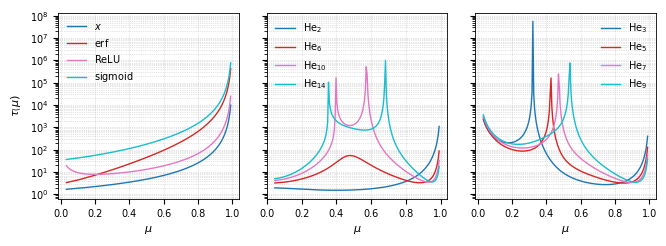

In [48]:
plot_three_panel_icml()

In [11]:
# ============================================================
# Global config
# ============================================================

# Default data file (you can override when calling the functions)
DATA_FILE = "t_exit_activations_icml_square.npz"

# μ-grid and dynamics parameters
mu_vals = np.linspace(0.01, 0.99, 200)
k_max = 16     # Hermite truncation (or generic truncation parameter)
R = 1.0        # outer radius in exit time
eps = 1e-3     # initial ball radius

# Hermite degrees
HERMITE_EVEN = [2, 6, 10, 14]
HERMITE_ODD  = [3, 5, 7, 9]
HERMITE = [2, 3, 4, 5]

In [12]:
# ============================================================
# Build activation configs (now with teacher_square switch)
# ============================================================

def make_config(name, label, sigma_r, sigma_r_prime, teacher_square, extra_args=None):
    """
    Build a single activation configuration.

    - sigma_r: student activation
    - sigma_r_prime: derivative of student activation
    - teacher_square:
         False -> teacher σ_base = σ_r
         True  -> teacher σ_base(x) = (σ_r(x))^2
    """
    if extra_args is None:
        extra_args = {}

    if teacher_square:
        def sigma_base(x, s=sigma_r):
            return s(x)**2
    else:
        sigma_base = sigma_r

    return {
        "name": name,
        "label": label,
        "sigma_r": sigma_r,
        "sigma_r_prime": sigma_r_prime,
        "sigma_base": sigma_base,
        "extra_args": extra_args,
    }


def build_activation_configs(teacher_square=False):
    """
    Returns a list of configs. Each config is a dict with:
        - 'name'  : short identifier (e.g. 'x', 'erf', 'He2')
        - 'label' : TeX label for the legend
        - 'sigma_r'
        - 'sigma_r_prime'
        - 'sigma_base'   (matching or squared depending on teacher_square)
        - 'extra_args'
    """
    configs = []

    # --- Standard activations ---
    configs.append(
        make_config(
            name="x",
            label=r"$x$",
            sigma_r=sigma_x,
            sigma_r_prime=sigma_x_prime,
            teacher_square=teacher_square,
        )
    )

    configs.append(
        make_config(
            name="erf",
            label=r"$\mathrm{erf}$",
            sigma_r=sigma_erf,
            sigma_r_prime=sigma_erf_prime,
            teacher_square=teacher_square,
        )
    )

    configs.append(
        make_config(
            name="relu",
            label=r"$\mathrm{ReLU}$",
            sigma_r=sigma_relu,
            sigma_r_prime=sigma_relu_prime,
            teacher_square=teacher_square,
        )
    )

    configs.append(
        make_config(
            name="sigmoid",
            label=r"$\mathrm{sigmoid}$",
            sigma_r=sigma_sigmoid,
            sigma_r_prime=sigma_sigmoid_prime,
            teacher_square=teacher_square,
        )
    )

    # --- Even Hermites ---
    for deg in HERMITE_EVEN:
        configs.append(
            make_config(
                name=f"He{deg}",
                label=rf"He$_{{{deg}}}$",
                sigma_r=make_sigma_r_hermite(deg),
                sigma_r_prime=make_sigma_r_prime_hermite(deg),
                teacher_square=teacher_square,
                extra_args={"degree": deg},
            )
        )

    # --- Odd Hermites ---
    for deg in HERMITE_ODD:
        configs.append(
            make_config(
                name=f"He{deg}",
                label=rf"He$_{{{deg}}}$",
                sigma_r=make_sigma_r_hermite(deg),
                sigma_r_prime=make_sigma_r_prime_hermite(deg),
                teacher_square=teacher_square,
                extra_args={"degree": deg},
            )
        )

    return configs


# ============================================================
# Part A — compute and save data
# ============================================================

def compute_t_exit_table(mu_vals, configs):
    """
    Compute t_exit(mu) for all activations.

    Returns:
        names  : list of short names
        labels : list of TeX labels
        T      : array shape (n_acts, n_mu)
    """
    n_acts = len(configs)
    n_mu   = len(mu_vals)
    T = np.zeros((n_acts, n_mu), dtype=float)

    names  = []
    labels = []

    for i, cfg in enumerate(configs):
        names.append(cfg["name"])
        labels.append(cfg["label"])
        t_vals = []

        for mu in mu_vals:
            t_mu = t_exit_from_mu(
                mu=mu,
                k_max=k_max,
                sigma_r=cfg["sigma_r"],
                sigma_r_prime=cfg["sigma_r_prime"],
                sigma_base=cfg["sigma_base"],
                R=R,
                eps=eps,
                **cfg["extra_args"],
            )
            t_vals.append(t_mu)

        T[i, :] = np.array(t_vals, dtype=float)

    return names, labels, T


def compute_and_save_t_exit_data(
    data_file=DATA_FILE,
    teacher_square=False,
):
    """
    Run this to compute all curves and save them to disk.

    teacher_square = False  -> matching teacher (σ_base = σ_r)
    teacher_square = True   -> squared teacher (σ_base(x) = σ_r(x)^2)
    """
    configs = build_activation_configs(teacher_square=teacher_square)
    names, labels, T = compute_t_exit_table(mu_vals, configs)

    np.savez(
        data_file,
        mu_vals=mu_vals,
        names=np.array(names, dtype=object),
        labels=np.array(labels, dtype=object),
        T=T,
        teacher_square=teacher_square,
    )
    mode = "squared-teacher" if teacher_square else "matching"
    print(f"[compute] Saved data to '{data_file}' (mode={mode})")

In [13]:
# ============================================================
# Part B — load and plot 3-panel ICML figure
# ============================================================

def load_t_exit_data(data_file=DATA_FILE):
    data = np.load(data_file, allow_pickle=True)
    mu_vals_loaded = data["mu_vals"]
    names = list(data["names"])
    labels = list(data["labels"])
    T = data["T"]
    teacher_square = bool(data.get("teacher_square", False))
    return mu_vals_loaded, names, labels, T, teacher_square


def plot_group(ax, mu_vals, group_names, names, labels, T, title=None):
    """
    Plot a subset of activations (group_names) on a given axis.
    """
    # Map name -> (index, label)
    idx = {n: i for i, n in enumerate(names)}
    label_dict = {n: lab for n, lab in zip(names, labels)}

    present = [g for g in group_names if g in idx]

    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    for color, n in zip(colors, present):
        j = idx[n]
        lab = label_dict[n]
        y = T[j, :]
        ax.plot(mu_vals, y, "-", color=color, label=lab)

    ax.set_yscale("log")
    ax.set_xlabel(r"$\mu$")
    #ax.set_ylabel(r"$t_{\mathrm{exit}}(\mu)$")
    ax.set_ylabel(r"$\tau(\mu)$")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.7)

    if title is not None:
        ax.set_title(title)

    ax.legend(frameon=False, fontsize=7)


def plot_three_panel_icml(
    data_file=DATA_FILE,
    out_file="t_exit_three_panels_icml.pdf",
    show=True,
):
    """
    Produce a single ICML-style figure with 3 panels:

      (a) x, erf, ReLU, sigmoid
      (b) He2, He6, He10, He14
      (c) He3, He5, He7, He9

    Works for both matching-teacher and squared-teacher data files.
    """
    set_icml_style()

    mu_loaded, names, labels, T, teacher_square = load_t_exit_data(data_file)

    fig, axes = plt.subplots(1, 3, sharey=True)

    # Panel 1: standard activations
    group1 = ["x", "erf", "relu", "sigmoid"]
    plot_group(
        axes[0],
        mu_loaded,
        group1,
        names,
        labels,
        T,
        #title="Standard activations",
    )

    # Panel 2: even Hermite
    group2 = [f"He{d}" for d in HERMITE_EVEN]
    plot_group(
        axes[1],
        mu_loaded,
        group2,
        names,
        labels,
        T,
        #title="Even Hermite",
    )

    # Panel 3: odd Hermite
    group3 = [f"He{d}" for d in HERMITE_ODD]
    plot_group(
        axes[2],
        mu_loaded,
        group3,
        names,
        labels,
        T,
        #title="Odd Hermite",
    )

    # Only leftmost panel keeps y-label (shared)
    axes[1].set_ylabel("")
    axes[2].set_ylabel("")

    # Optional: annotate mode in a suptitle
    mode_text = "Squared teacher" if teacher_square else "Matching teacher"
    fig.suptitle(mode_text, y=1.02, fontsize=8)

    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()
    else:
        plt.close(fig)

In [14]:
# Squared teacher: σ_base(x) = σ_r(x)^2
compute_and_save_t_exit_data(
    data_file="t_exit_activations_icml_sqteacher.npz",
    teacher_square=True,
)

/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_33511/3972582843.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_33511/2481477585.py:45: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_33511/3972582843.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, err = quad(


[compute] Saved data to 't_exit_activations_icml_sqteacher.npz' (mode=squared-teacher)


In [84]:
# ============================================================
# Global config
# ============================================================

DATA_FILE = "t_exit_activations_icml_squarematch_test.npz"

mu_vals = np.linspace(0.03, 0.99, 200)
k_max = 10
R = 1.0
eps = 1e-3

# NEW unified Hermite list
HERMITE = [2, 3, 4, 5]

In [85]:
# ============================================================
# Build activation configs (with teacher_square switch)
# ============================================================

def make_config(name, label, sigma_r, sigma_r_prime, teacher_square, extra_args=None):
    if extra_args is None:
        extra_args = {}

    if teacher_square:
        def sigma_base(x, s=sigma_r):
            return s(x)**2
    else:
        sigma_base = sigma_r

    return {
        "name": name,
        "label": label,
        "sigma_r": sigma_r,
        "sigma_r_prime": sigma_r_prime,
        "sigma_base": sigma_base,
        "extra_args": extra_args,
    }


def build_activation_configs(teacher_square=False):
    configs = []

    # Standard activations
    configs.append(make_config("x", r"$x$", sigma_x, sigma_x_prime, teacher_square))
    configs.append(make_config("erf", r"$\mathrm{erf}$", sigma_erf, sigma_erf_prime, teacher_square))
    configs.append(make_config("relu", r"$\mathrm{ReLU}$", sigma_relu, sigma_relu_prime, teacher_square))
    configs.append(make_config("sigmoid", r"$\mathrm{sigmoid}$", sigma_sigmoid, sigma_sigmoid_prime, teacher_square))

    # Hermite activations: He2, He3, He4, He5
    for deg in HERMITE:
        configs.append(
            make_config(
                name=f"He{deg}",
                label=rf"He$_{{{deg}}}$",
                sigma_r=make_sigma_r_hermite(deg),
                sigma_r_prime=make_sigma_r_prime_hermite(deg),
                teacher_square=teacher_square,
                extra_args={"degree": deg},
            )
        )

    return configs

In [86]:
# ============================================================
# Part A — Compute and save
# ============================================================

def compute_t_exit_table(mu_vals, configs):
    n_acts = len(configs)
    n_mu   = len(mu_vals)
    T = np.zeros((n_acts, n_mu))

    names, labels = [], []

    for i, cfg in enumerate(configs):
        names.append(cfg["name"])
        labels.append(cfg["label"])

        vals = []
        for mu in mu_vals:
            t_mu = t_exit_from_mu(
                mu=mu,
                k_max=k_max,
                sigma_r=cfg["sigma_r"],
                sigma_r_prime=cfg["sigma_r_prime"],
                sigma_base=cfg["sigma_base"],
                R=R,
                eps=eps,
                **cfg["extra_args"],
            )
            vals.append(t_mu)

        T[i, :] = vals

    return names, labels, T


def compute_and_save_t_exit_data(data_file=DATA_FILE, teacher_square=False):
    configs = build_activation_configs(teacher_square)
    names, labels, T = compute_t_exit_table(mu_vals, configs)

    np.savez(
        data_file,
        mu_vals=mu_vals,
        names=np.array(names, dtype=object),
        labels=np.array(labels, dtype=object),
        T=T,
        teacher_square=teacher_square,
    )

    print(f"[compute] Saved {data_file} (teacher_square={teacher_square})")

In [87]:
# ============================================================
# Part B — Plot 3-panel ICML figure
# ============================================================

def load_t_exit_data(data_file=DATA_FILE):
    data = np.load(data_file, allow_pickle=True)
    return (
        data["mu_vals"],
        list(data["names"]),
        list(data["labels"]),
        data["T"],
        bool(data["teacher_square"]),
    )


def plot_group(ax, mu_vals, group_names, names, labels, T, title=None):
    index = {n: i for i, n in enumerate(names)}

    present = [g for g in group_names if g in index]
    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    for color, name in zip(colors, present):
        j = index[name]
        ax.plot(mu_vals, T[j, :], '-', color=color, label=labels[j])

    ax.set_yscale("log")
    ax.set_xlabel(r"$\mu$")
    if title !=None:
        ax.set_title(title)
    ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
    ax.legend(frameon=False,ncol=2, fontsize=7)


def plot_two_panel_icml(data_file=DATA_FILE,
                          out_file="t_exit_two_panels_icml_square.pdf",
                          show=True):

    set_icml_style()

    mu_vals, names, labels, T, teacher_square = load_t_exit_data(data_file)

    fig, axes = plt.subplots(2, 1, figsize=(4,7), sharey=True)

    # Panel 1: standard activations
    plot_group(
        axes[0],
        mu_vals,
        ["x", "erf", "relu", "sigmoid"],
        names,
        labels,
        T,
        #title="Standard activations",
    )

    # Panel 2: He2, He3
    plot_group(
        axes[1],
        mu_vals,
        ["He2", "He3", "He4", "He5"],
        names,
        labels,
        T,
        #title="Hermite (2 & 3)",
    )

    # Panel 3: He4, He5
    """plot_group(
        axes[2],
        mu_vals,
        ["He4", "He5"],
        names,
        labels,
        T,
        title="Hermite (4 & 5)",
    )"""

    axes[1].set_ylabel("")
    #axes[2].set_ylabel("")

    """fig.suptitle(
        "Squared teacher" if teacher_square else "Matching teacher",
        y=1.02,
        fontsize=8,
    )"""

    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")
    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()

In [88]:
compute_and_save_t_exit_data(
    data_file="t_exit_sqteacher.npz",
    teacher_square=True,
)

/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_95910/2481477585.py:45: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
/var/folders/r2/0ryqb7352pj4s03jv51f3w180000gn/T/ipykernel_95910/3972582843.py:8: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(


[compute] Saved t_exit_sqteacher.npz (teacher_square=True)


In [89]:
def plot_group(ax, mu_vals, group_names, names, labels, T, title=None):
    """
    Plot a subset of activations on a given axis.
    Each axis auto-scales independently.
    """
    name_to_index = {n: i for i, n in enumerate(names)}
    present = [g for g in group_names if g in name_to_index]

    colors = plt.cm.tab10(np.linspace(0, 1, len(present)))

    for color, name in zip(colors, present):
        j = name_to_index[name]
        ax.plot(mu_vals, T[j, :], "-", color=color, label=labels[j])

    ax.set_yscale("log")

    # Grid for all
    ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

    if title:
        ax.set_title(title, fontsize=8)

    ax.legend(frameon=False,ncol=2, fontsize=7)


def plot_two_panel_icml(
    data_file=DATA_FILE,
    out_file="t_exit_two_panels_icml.pdf",
    show=True,
):
    """
    Two stacked ICML-style plots:
      - top: standard activations (same x ticks but no labels)
      - bottom: Hermite activations (full μ axis)
      - independent y-axes
      - grid everywhere
    """

    set_icml_style()

    mu_vals, names, labels, T, teacher_square = load_t_exit_data(data_file)

    fig, axes = plt.subplots(2, 1, figsize=(3, 3))

    # ------------------------------------------------------
    # PANEL 1 — standard activations (NO μ label, but ticks appear)
    # ------------------------------------------------------
    plot_group(
        axes[0],
        mu_vals,
        ["x", "erf", "relu", "sigmoid"],
        names,
        labels,
        T,
    )

    # Put x-ticks but hide their labels
    axes[0].set_xticks(np.linspace(0, 1, 8))
    axes[0].set_xticklabels([])   # hide tick labels
    axes[0].set_xlabel("")        # do not write μ

    axes[0].set_ylabel(r"$\tau(\mu)$")

    # ------------------------------------------------------
    # PANEL 2 — Hermite activations
    # ------------------------------------------------------
    plot_group(
        axes[1],
        mu_vals,
        ["He2", "He3", "He4", "He5"],
        names,
        labels,
        T,
    )

    # Bottom axis shows μ normally
    axes[1].set_xticks(np.linspace(0, 1, 8))
    # Format tick labels with one decimal max
    axes[1].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    axes[1].set_xlabel(r"$\mu$")
    axes[1].set_ylabel(r"$\tau(\mu)$")

    # ------------------------------------------------------
    # Layout
    # ------------------------------------------------------
    fig.tight_layout()
    fig.savefig(out_file, bbox_inches="tight")

    print(f"[plot] Saved figure to '{out_file}'")

    if show:
        plt.show()


[plot] Saved figure to 't_exit_sqteacher_icml_test.pdf'


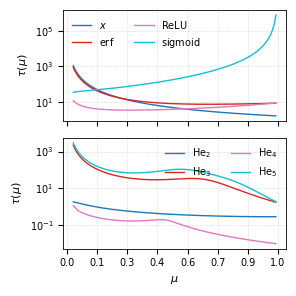

In [90]:
plot_two_panel_icml(
    data_file="t_exit_sqteacher.npz",
    out_file="t_exit_sqteacher_icml_test.pdf",
)